Link to Medium blog post: https://towardsdatascience.com/how-to-change-semi-structured-text-into-a-pandas-dataframe-ef531d6baab4

First import the libraries that we will use:

In [9]:
pip install requests

  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached charset_normalizer-3.3.2-cp311-cp311-macosx_10_9_x86_64.whl.metadata (33 kB)
Using cached requests-2.31.0-py3-none-any.whl (62 kB)
Using cached charset_normalizer-3.3.2-cp311-cp311-macosx_10_9_x86_64.whl (121 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 638.0 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 914.7 kB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io

And here is the code to download the data:

In [44]:
url = 'https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/heathrowdata.txt'
file = io.StringIO(requests.get(url).text)

Now we are nearly ready to read the file. I needed to take a look at the raw file first and this showed me that the first 5 lines were unstructured text. I would need to skip those lines to read the file as csv.

The next two lines were the column names. I decided to skip those, too, and provide my own names. Those names are ‘Year’, ‘Month’, ‘Tmax’, ‘Tmin’, ‘AF’, ‘Rain’, ‘Sun’. The first two are obvious, Tmax and Tmin are the maximum and minimum temperatures in a month, AF is the number of days when there was air frost in a month, Rain is the number of millimeters of rain and Sun is the number of hours of sunshine.

I recorded these things in variables like this:

In [45]:
col_names = ('Year','Month','Tmax','Tmin','AF','Rain','Sun')
comment_lines = 5
header = 2

These will be used in the read_csv call.

read_csv needs some other parameters set for this particular job. It needs to know the delimiter used in the file, the default is a comma (what else?) but here the delimiter is a space character, in fact more than one space character. So, I need to tell pandas this (delimiter=` ´). And because there are several spaces between the fields, Pandas needs to know to ignore these (skipinitialspace=True).

I need to tell it that it should skip the first few rows (skiprows=comment_lines+header), not regard any row in the file as a header (header=None) and the names of the columns (names=col_names).

Finally, I know that when it gets to the year 2020 the number of columns change. This would normally throw an exception and no dataframe would be returned. But setting error_bad_lines=False suppresses the error and ignores the bad lines.

Here is the resulting code that creates the dataframe weather.



In [46]:
weather = pd.read_csv(file,
   skiprows=comment_lines + header,
   header=None,
   names=col_names,
   delimiter=' ',
   skipinitialspace=True,
   on_bad_lines='skip')

In [47]:
weather

,Year,Month,Tmax,Tmin,AF,Rain,Sun
0,1948,1,8.9,3.3,---,85.0,---
1,1948,2,7.9,2.2,---,26.0,---
2,1948,3,14.2,3.8,---,14.0,---
3,1948,4,15.4,5.1,---,35.0,---
4,1948,5,18.1,6.9,---,57.0,---
...,...,...,...,...,...,...,...
895,2022,8,27.0,15.9,0,54.4,234.3#
896,2022,9,20.2,11.8,0,86.0,119.1#
897,2022,10,18.3,10.4,0,81.4,132.8#
898,2022,11,13.2,7.6,0,123.8,69.9#


The individual data items need fixing but the next job is to append the rest of the file. This time I’ll read the file again, using similar parameters but I’ll find the length of the dataframe that I’ve just read and skip all of those lines. The remaining part of the file contains 8 columns, so I need to add a new column name as well. Otherwise the call to read_csv is similar to before.

In [48]:
file.seek(0)
col_names = ('Year','Month','Tmax','Tmin','AF','Rain','Sun', 'Status')
rows_to_skip = comment_lines+header+len(weather)
weather2 = pd.read_csv(file,
   skiprows=rows_to_skip,
   header=None,
   names=col_names,
   delimiter=' ',
   skipinitialspace=True,
   on_bad_lines='skip')

In [49]:
weather2

,Year,Month,Tmax,Tmin,AF,Rain,Sun,Status
0,2023,1,9.0,2.5,10,66.2*,68.2#,Provisional
1,2023,2,10.8,3.4,6,4.2,81.3#,Provisional
2,2023,3,11.5,5.2,1,92.4,60.2#,Provisional
3,2023,4,14.6,5.9,0,65.8,151.1#,Provisional
4,2023,5,18.6,9.3,0,38.4,196.6#,Provisional
5,2023,6,25.3,13.5,0,56.8,250.2#,Provisional
6,2023,7,22.9,14.0,0,61.4,150.1#,Provisional
7,2023,8,23.0,13.8,0,53.0,171.1#,Provisional
8,2023,9,24.4,14.7,0,59.4,167.9#,Provisional
9,2023,10,18.1,10.2,0,116.8,112.9#,Provisional


Similar to the other dataframe but with an extra column.

The next trick is to merge the two dataframes and to do this properly I have to make them the same shape. So, I have a choice, delete the Status column in the second dataframe or add one to the first dataframe. For the purposes of this exercise, I’ve decided to not lose the status information and add a column to the first. The extra column is called Status and for the 2020 data its value is ‘Provisional’. So, I’ll create a Status column in the first dataframe and set all the values to ‘Final’.

In [50]:
weather['Status']='Final'

And now I’ll append the second dataframe to the first and add the parameter ignore_index=True in order not to duplicate the indices but rather create a new index for the combined dataframe.

In [51]:
weather = pd.concat([weather, weather2], ignore_index=True)

weather

,Year,Month,Tmax,Tmin,AF,Rain,Sun,Status
0,1948,1,8.9,3.3,---,85.0,---,Final
1,1948,2,7.9,2.2,---,26.0,---,Final
2,1948,3,14.2,3.8,---,14.0,---,Final
3,1948,4,15.4,5.1,---,35.0,---,Final
4,1948,5,18.1,6.9,---,57.0,---,Final
...,...,...,...,...,...,...,...,...
909,2023,10,18.1,10.2,0,116.8,112.9#,Provisional
910,2023,11,11.8,5.4,3,78.4,74.9#,Provisional
911,2023,12,10.9,5.9,3,76.4,21.0#,Provisional
912,2024,1,8.4,2.5,8,50.6,71.4#,Provisional


Now we have to deal with the data in each column. Let’s take a look at the data types.

In [52]:
weather.dtypes

Year        int64
Month       int64
Tmax      float64
Tmin      float64
AF         object
Rain       object
Sun        object
Status     object
dtype: object

As you can see, Pandas has done its best to interpret the data types: Tmax, Tmin and Rain are correctly identified as floats and Status is an object (basically a string). But AF and Sun have been interpreted as strings, too, although in reality they ought to be numbers. The reason for this is that some of the values in the Sun and AF columns are the string ‘ — -’ (meaning no data) or the number has a # symbol attached to it.

It’s only the Sun column that has the # symbol attached to the number of hours of sunshine, so the first thing is to just get rid of that character in that column. A string-replace does the job; the code below removes the character by replacing it with an empty string.

In [53]:
weather['Sun']=weather['Sun'].str.replace('#','')

Now the numbers in the Sun column are correctly formatted but Pandas still regards the Sun and AF columns data as strings so we can’t read the column as numbers and cannot therefore draw charts using this data.

Changing the representation of the data is straightforward; we use the function to_numeric to convert the string values to numbers. Using this function the string would convert the string “123.4” to a floating point number 123.4. But some of the values in the columns that we want to convert are the string ‘ — -’, which cannot be reasonably interpreted as a number.

The trick is to set the parameter errors to coerce. This will force any strings that cannot be interpreted as numbers to the value NaN (not a number) which is the Python equivalent of a null numeric value. And this is exactly what we want because the string ‘ — -’ in this dataframe means ‘no data’.

Here is the code to correct the values in the two columns.

In [54]:
weather['AF']=pd.to_numeric(weather['AF'], errors='coerce')
weather['Sun']=pd.to_numeric(weather['Sun'], errors='coerce')

The dataframe now looks like this:

In [55]:
weather

,Year,Month,Tmax,Tmin,AF,Rain,Sun,Status
0,1948,1,8.9,3.3,NaN,85.0,NaN,Final
1,1948,2,7.9,2.2,NaN,26.0,NaN,Final
2,1948,3,14.2,3.8,NaN,14.0,NaN,Final
3,1948,4,15.4,5.1,NaN,35.0,NaN,Final
4,1948,5,18.1,6.9,NaN,57.0,NaN,Final
...,...,...,...,...,...,...,...,...
909,2023,10,18.1,10.2,0.0,116.8,112.9,Provisional
910,2023,11,11.8,5.4,3.0,78.4,74.9,Provisional
911,2023,12,10.9,5.9,3.0,76.4,21.0,Provisional
912,2024,1,8.4,2.5,8.0,50.6,71.4,Provisional


You can see the NaN values and if we look at the data types again we see this:

In [56]:
weather.dtypes

Year        int64
Month       int64
Tmax      float64
Tmin      float64
AF        float64
Rain       object
Sun       float64
Status     object
dtype: object

To illustrate that this is what we want here is a plot of the rainfall for the year 2000.

<Axes: xlabel='Month'>

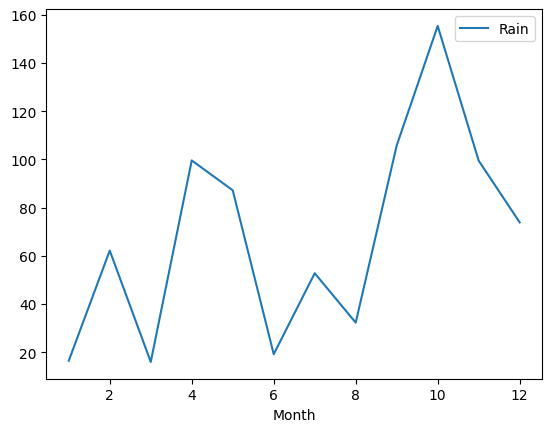

In [57]:
weather[weather.Year==2000].plot(x='Month', y='Rain')

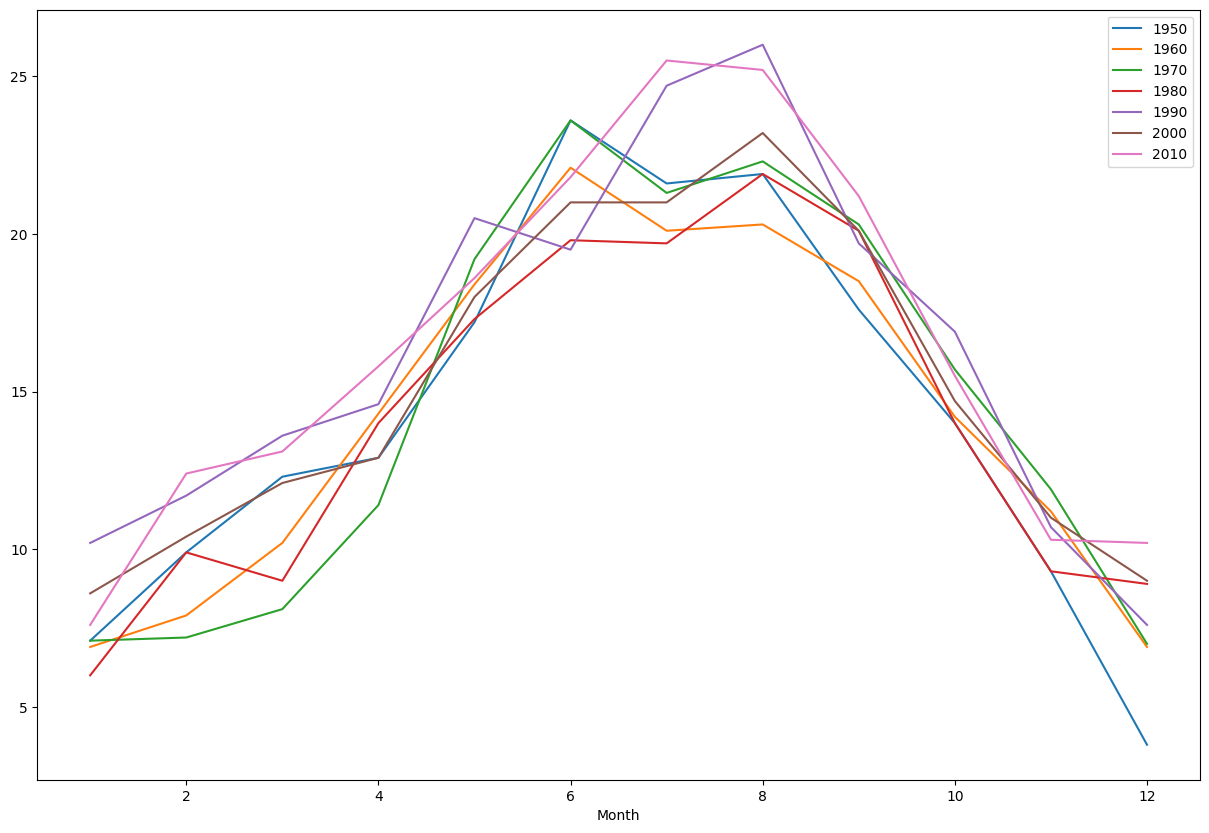

In [58]:
ax = weather[weather.Year==1950].plot(x='Month', y='Tmax',
   label='1950')
ax = weather[weather.Year==1960].plot(x='Month', y='Tmax', 
   label='1960',ax=ax)
ax = weather[weather.Year==1970].plot(x='Month', y='Tmax',  
   label='1970',ax=ax)
ax = weather[weather.Year==1980].plot(x='Month', y='Tmax', 
   label='1980',ax=ax)
ax = weather[weather.Year==1990].plot(x='Month', y='Tmax', 
   label='1990',ax=ax)
ax = weather[weather.Year==2000].plot(x='Month', y='Tmax', 
   label='2000',ax=ax)
weather[weather.Year==2019].plot(x='Month', y='Tmax', label = 
   '2010', ax=ax, figsize=(15,10))